In [ ]:
 from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install -q xgboost scikit-learn shap imbalanced-learn

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, auc, roc_curve
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

In [ ]:
refined_zone_path = "/content/drive/MyDrive/ProjetoAplicadoII/03_refined_zone/bases_processadas/estabelecimento.parquet"
RANDOM_STATE = 42
TOP_K = 200

CNAES_INTERESSE = {
    6201501, 6201502, 6202300, 6203100, 2640001, 2651500, 2652300,
    6201501, 6201502, 6202300, 6203100
}

print('Carregando Bas:', refined_zone_path)
df = pd.read_parquet(refined_zone_path)
print('Linhas / Colunas:', df.shape)
df.head()

Carregando Bas: /content/drive/MyDrive/ProjetoAplicadoII/03_refined_zone/bases_processadas/estabelecimento.parquet
Linhas / Colunas: (1649701, 16)


,cnpj_basico,cnpj_ordem,cnpj_dv,cnpj_completo,id_matriz_filial,nome_fantasia,situacao_cadastral,cnae_fiscal_principal,tipo_logradouro,cep,uf,correio_eletronico,bairro,situacao_especial,data_inicio_atividade,municipio
0,15164625,0001,66,15164625000166,1,None,2,4929902,RUA,86690000,PR,None,PARQUE RESIDENCIAL PORTAL DAS PRIMAVERAS,None,20120302,COLORADO
1,15164804,0001,01,15164804000101,1,None,2,5611203,QUADRA,73062702,DF,None,SETOR OESTE (SOBRADINHO),None,20120308,BRASILIA
2,15164857,0001,14,15164857000114,1,None,2,5611203,AVENIDA,36046000,MG,ALBCONTABILIDADE@GMAIL.COM,SANTA TEREZINHA,None,20120308,JUIZ DE FORA
3,15165045,0001,93,15165045000193,1,None,2,4543900,RUA,78255000,MT,marisadosanjos@hotmail.com,centro,None,20120308,JAURU
4,15165147,0001,09,15165147000109,1,None,2,4712100,RUA,63460000,CE,marcosmagalhaesguerra@hotmail.com,CENTRO,None,20120308,PEREIRO


In [ ]:
print(df.columns.tolist())

['cnpj_basico', 'cnpj_ordem', 'cnpj_dv', 'cnpj_completo', 'id_matriz_filial', 'nome_fantasia', 'situacao_cadastral', 'cnae_fiscal_principal', 'tipo_logradouro', 'cep', 'uf', 'correio_eletronico', 'bairro', 'situacao_especial', 'data_inicio_atividade', 'municipio']


In [ ]:
def year_from_yyyymmdd(x):
    try:
        s = str(int(x))
        return int(s[:4])
    except:
        return np.nan

def preprocess(df):
    df = df.copy()

    df['cnpj_basico'] = df['cnpj_basico'].astype(str).str.zfill(8)
    df['situacao_cadastral'] = pd.to_numeric(df['situacao_cadastral'], errors='coerce')
    df['cnae'] = pd.to_numeric(df['cnae_fiscal_principal'], errors='coerce')


    df['is_ativa'] = (df['situacao_cadastral'] == 2).astype(int)


    df['is_potencial'] = df.apply(lambda r: int((r['cnae'] in CNAES_INTERESSE) and (r['is_ativa'] == 1)), axis=1)

    if 'data_inicio_atividade' in df.columns:
        df['ano_inicio'] = df['data_inicio_atividade'].apply(year_from_yyyymmdd)
        current_year = pd.Timestamp.now().year
        df['anos_atividade'] = (current_year - df['ano_inicio']).clip(lower=0)
    else:
        df['ano_inicio'] = np.nan
        df['anos_atividade'] = np.nan


    counts = df['cnpj_basico'].value_counts()
    df['num_filiais_raiz'] = df['cnpj_basico'].map(counts).fillna(1).astype(int)
    df['is_grande_conta'] = (df['num_filiais_raiz'] > 1).astype(int)


    df['uf'] = df['uf'].astype(str).str.strip().str.upper().fillna('UNK')
    df['municipio'] = df['municipio'].astype(str).str.strip().str.upper().fillna('UNK')


    def map_vertical(cnae):
        try:
            s = str(int(cnae)).zfill(7)
            prefix = int(s[:2])
        except:
            return 'unknown'
        if prefix == 62:
            return 'software'
        if prefix == 26:
            return 'industria'
        if prefix == 71:
            return 'servicos_pd'
        if prefix == 61:
            return 'telecom'
        return 'outros'

    df['vertical'] = df['cnae'].apply(map_vertical)


    df['uf_vert'] = df['uf'] + '_' + df['vertical'].astype(str)
    densidade = df['uf_vert'].value_counts()
    df['cluster_densidade'] = df['uf_vert'].map(densidade).fillna(0).astype(int)

    return df

df = preprocess(df)
print('shape preprocessamento:', df.shape)
df[['cnpj_basico','nome_fantasia','cnae','is_ativa','is_potencial','anos_atividade','is_grande_conta','vertical','cluster_densidade']].head(8)

shape preprocessamento: (1649701, 27)


,cnpj_basico,nome_fantasia,cnae,is_ativa,is_potencial,anos_atividade,is_grande_conta,vertical,cluster_densidade
0,15164625,None,4929902,1,0,13,0,outros,163416
1,15164804,None,5611203,1,0,13,0,outros,39895
2,15164857,None,5611203,1,0,13,0,outros,242771
3,15165045,None,4543900,1,0,13,0,outros,48353
4,15165147,None,4712100,1,0,13,0,outros,62585
5,15165197,None,5620101,1,0,13,0,outros,107174
6,15165222,None,4399103,1,0,13,0,outros,107174
7,15165273,None,5620101,1,0,13,0,outros,39895


In [ ]:
def definir_features(df):
    numericos = ['anos_atividade','cluster_densidade','num_filiais_raiz','is_ativa','is_grande_conta']
    numericos = [f for f in numericos if f in df.columns]
    X_num = df[numericos].fillna(-1).copy()

    categoricos = ['vertical','uf']
    categoricos = [f for f in categoricos if f in df.columns]
    X_cat = df[categoricos].fillna('UNK').copy()
    X_cat = pd.get_dummies(X_cat, drop_first=True)

    X = pd.concat([X_num.reset_index(drop=True), X_cat.reset_index(drop=True)], axis=1)
    return X, numericos, categoricos

X, num_feats, cat_feats = definir_features(df)
y = df['is_potencial'].astype(int).fillna(0)
print('X shape:', X.shape, 'y positives:', y.sum())

X shape: (1649701, 35) y positives: 5687


In [ ]:
def preds_metricas(y_true, y_pred, y_score):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    roc = roc_auc_score(y_true, y_score) if len(np.unique(y_true))>1 else np.nan
    p, r, _ = precision_recall_curve(y_true, y_score)
    pr_auc = auc(r, p)
    return {'acc':acc,'prec':prec,'rec':rec,'f1':f1,'roc':roc,'pr_auc':pr_auc}

def evaluate_cv(clf, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=RANDOM_STATE)
    metrics = []
    for train_idx, test_idx in skf.split(X, y):
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_te)
        if hasattr(clf, 'predict_proba'):
            y_score = clf.predict_proba(X_te)[:,1]
        else:
            y_score = clf.decision_function(X_te)
            y_score = (y_score - y_score.min())/(y_score.max()-y_score.min())
        metrics.append(preds_metricas(y_te, y_pred, y_score))

    agg = {k: np.mean([m[k] for m in metrics if not np.isnan(m[k])]) for k in metrics[0].keys()}
    return agg


lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_STATE)
rf = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=RANDOM_STATE, n_jobs=-1)
neg = (y==0).sum(); pos = (y==1).sum() or 1
scale_pos_weight = neg/pos
xgb_clf = xgb.XGBClassifier(n_estimators=200, scale_pos_weight=scale_pos_weight, use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE, n_jobs=4)

print('Avaliando Regressão Logística...')
res_lr = evaluate_cv(lr, X, y, folds=5)
print('Resultados - Regressão Logística:', res_lr)

print('Avaliando Random Forest...')
res_rf = evaluate_cv(rf, X, y, folds=5)
print('Resultados - Random Forest:', res_rf)

print('Avaliando XGBoost...')
res_xgb = evaluate_cv(xgb_clf, X, y, folds=5)
print('Resultados - XGBoost:', res_xgb)


resultados = {'logreg':res_lr, 'rf':res_rf, 'xgb':res_xgb}
melhor = max(resultados.keys(), key=lambda k: resultados[k]['pr_auc'] if not np.isnan(resultados[k]['pr_auc']) else -1)
print('Melhor modelo por PR-AUC:', melhor)

Avaliando Regressão Logística...
Resultados - Regressão Logística: {'acc': np.float64(0.9964278374896572), 'prec': np.float64(0.4911401541418354), 'rec': np.float64(1.0), 'f1': np.float64(0.6587341339438808), 'roc': np.float64(0.9983731629003572), 'pr_auc': np.float64(0.5351974636638961)}
Avaliando Random Forest...
Resultados - Random Forest: {'acc': np.float64(0.996496334764639), 'prec': np.float64(0.4958503671618787), 'rec': np.float64(0.9720423276497675), 'f1': np.float64(0.6566967226566051), 'roc': np.float64(0.9979876975156321), 'pr_auc': np.float64(0.5265860111203422)}
Avaliando XGBoost...
Resultados - XGBoost: {'acc': np.float64(0.9964599645155028), 'prec': np.float64(0.49333431342133716), 'rec': np.float64(0.9903292820343982), 'f1': np.float64(0.6585786077980368), 'roc': np.float64(0.9984133025776718), 'pr_auc': np.float64(0.5405315694592784)}
Melhor modelo por PR-AUC: xgb


In [ ]:
melhor_modelo = {'logreg':lr, 'rf':rf, 'xgb':xgb_clf}[melhor]
melhor_modelo.fit(X, y)
if hasattr(melhor_modelo, 'predict_proba'):
    probs = melhor_modelo.predict_proba(X)[:,1]
else:
    probs = melhor_modelo.decision_function(X)
    probs = (probs - probs.min())/(probs.max()-probs.min())

df_scored = df.copy().reset_index(drop=True)
df_scored['model_proba'] = probs * 1.0


def heuristic_score(row):
    score = 0.0
    score += 25 if row.get('is_grande_conta',0)==1 else 10
    vert_pontos = {'software':20, 'servicos_pd':15, 'telecom':10, 'industria':5}.get(row.get('vertical','outros'), 5)
    score += vert_pontos
    anos = row.get('anos_atividade', 0)
    if pd.isna(anos): anos = 0
    if anos < 1: score += 10
    elif anos <= 3: score += 12
    else: score += 15
    cd = row.get('cluster_densidade', 0)
    if cd > 500: score += 30
    elif cd >= 100: score += 20
    elif cd >= 10: score += 15
    else: score += 10
    year = row.get('ano_inicio', None)
    if year == pd.Timestamp.now().year: score += 5
    return min(score, 100)

df_scored['heuristic_score'] = df_scored.apply(heuristic_score, axis=1)
df_scored['modelo_score_100'] = df_scored['model_proba'] * 100
df_scored['final_score'] = 0.6 * df_scored['modelo_score_100'] + 0.4 * df_scored['heuristic_score']


top_final = df_scored.sort_values('final_score', ascending=False).head(TOP_K)
top_modelo = df_scored.sort_values('model_proba', ascending=False).head(TOP_K)
print('Top_final:')
top_final[['cnpj_completo','nome_fantasia','uf','municipio','model_proba','heuristic_score','final_score']].head(10)

Top_final:


,cnpj_completo,nome_fantasia,uf,municipio,model_proba,heuristic_score,final_score
749662,26314062002377,SANKHYA JIVA TECNOLOGIA E INOVACAO,MG,PATOS DE MINAS,0.999892,90.0,95.993491
429770,26314062002105,SANKHYA JIVA TECNOLOGIA E INOVACAO LTDA,MG,UBERLANDIA,0.999854,90.0,95.991261
673587,32891978000420,None,RJ,RIO DE JANEIRO,0.999833,90.0,95.989952
334155,26314062001303,None,MG,UBERLANDIA,0.999722,90.0,95.983324
576198,11518017000402,TECHPARK TENOLOGIA & MOBILIDADE,MG,BELO HORIZONTE,0.999675,90.0,95.980490
1636859,19138940000684,None,RJ,MACAE,0.999667,90.0,95.980032
230517,53113791002338,None,RJ,RIO DE JANEIRO,0.999598,90.0,95.975876
229472,19138940000846,SPREAD SISTEMAS,RJ,RIO DE JANEIRO,0.999598,90.0,95.975876
668390,36608018000207,B R DE AVELLAR JUNIOR INOVA EIRELI,RS,LAJEADO,0.999351,90.0,95.961072
1503098,48237551000361,None,RS,SANTO ANGELO,0.998712,90.0,95.922743


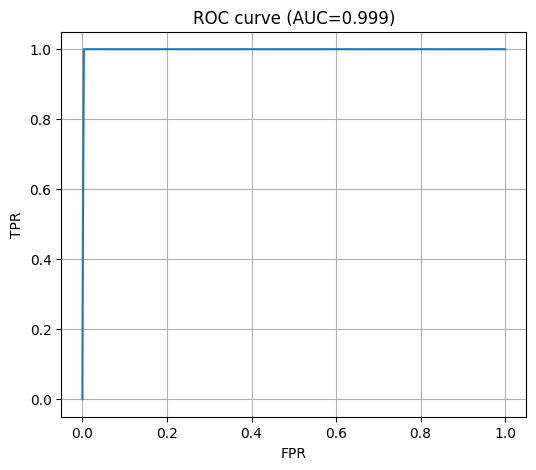

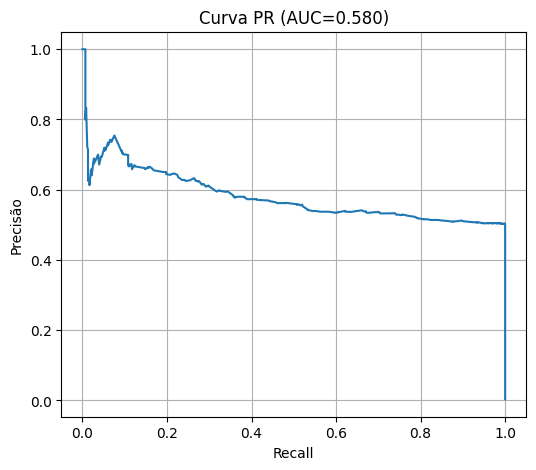

In [ ]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
melhor_modelo.fit(X_tr, y_tr)
if hasattr(melhor_modelo, 'predict_proba'):
    y_score = melhor_modelo.predict_proba(X_te)[:,1]
else:
    y_score = melhor_modelo.decision_function(X_te)
    y_score = (y_score - y_score.min())/(y_score.max()-y_score.min())

fpr, tpr, _ = roc_curve(y_te, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr)
plt.title(f'ROC curve (AUC={roc_auc:.3f})')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.grid(True)
plt.show()

p, r, _ = precision_recall_curve(y_te, y_score)
pr_auc = auc(r, p)
plt.figure(figsize=(6,5))
plt.plot(r, p)
plt.title(f'Curva PR (AUC={pr_auc:.3f})')
plt.xlabel('Recall'); plt.ylabel('Precisão')
plt.grid(True)
plt.show()

In [ ]:
if hasattr(melhor_modelo, 'feature_importances_'):
    fi = pd.Series(melhor_modelo.feature_importances_, index=X.columns).sort_values(ascending=False)
    display(fi.head(30))
else:
    print('O modelo não tem feature_importances_. Considerar usar Tmodelo baseado em Tree ou SHAP para detalhes.')

,0
cluster_densidade,0.657274
vertical_servicos_pd,0.232020
vertical_telecom,0.107012
uf_BA,0.000320
uf_RN,0.000281
uf_RJ,0.000265
uf_PA,0.000245
uf_DF,0.000218
vertical_software,0.000190
uf_MG,0.000162
